# Ask GPT-4v

> Python module for processing image by asking GPT via OpenAI API

In [ ]:
#| default_exp vision.gpt4v

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from IPython.display import Image
import base64
import glob
import json
import openai
import requests

## Process images with GPT

A simple approach to process image with GPT is to encode image as base64 string and ask about its information. Starting with some local images:

In [ ]:
#| eval: false
import os
from pathlib import Path

data_path = Path(os.getenv("LLMCAM_DATA", "../data")).absolute()
files = sorted(glob.glob(f"{data_path}/cap_*.jpg"))
len(files), files[:9]

(640,
 ['/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_15:59:06_Presidentinlinna.jpg',
  '/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_16:00:11_Presidentinlinna.jpg',
  '/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_16:01:16_Etelasatama.jpg',
  '/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_16:02:21_Etelasatama.jpg',
  '/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_16:05:31_Olympiaterminaali.jpg',
  '/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_16:06:36_Olympiaterminaali.jpg',
  '/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_16:07:41_Torni.jpg',
  '/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_16:09:51_Tuomiokirkko.jpg',
  '/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.09.28_16:15:11_Presidentinlinna.jpg'])

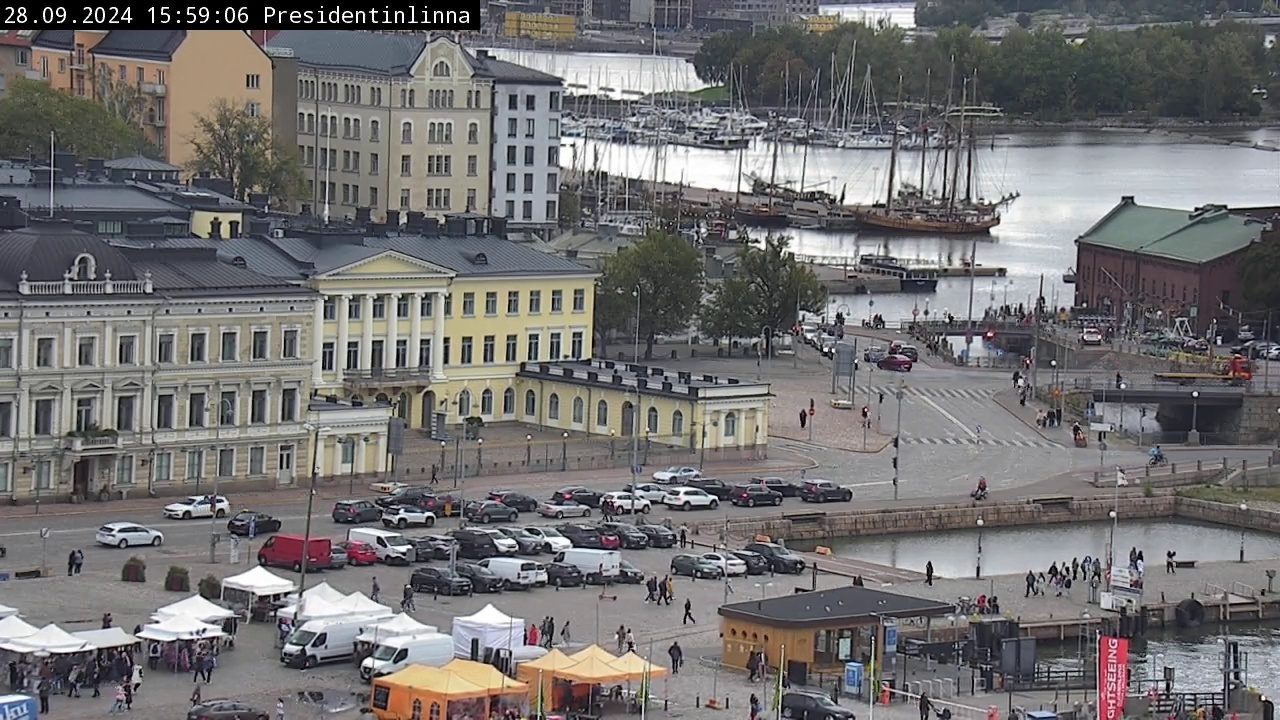

In [ ]:
#| eval: false
Image(files[0])

In [ ]:
#| export
def encode_image(fname: str):
    """Encode an image file as base64 string"""
    with open(fname, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

In [ ]:
show_doc(encode_image)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/vision/gpt4v.py#L17){target="_blank" style="float:right; font-size:smaller"}

### encode_image

>      encode_image (fname:str)

*Encode an image file as base64 string*

Example of encoding:

In [ ]:
#| eval: false
base64_image = encode_image(files[0])
base64_image[:9]

'/9j/4AAQS'

With the encoded image, we can use OpenAI API to intiate a conversation asking about the image. We can also specify the format of outputs:

In [ ]:
#|export
question = """
    Describe this image quantitatively as many as possible in json format. All the value should numbers.
    
    ##### EXAMPLE OUTPUT FORMAT
    {
        'timestamp': '2024-10-06T19:04:14',
        'location': 'Kauppatori',
        'dimensions': '1280 x 720',
        'building': 10,
        'buildings_height_range': '3-5 stories',
        'car': 5,
        'truck': 2,
        'boat': 4,
        'available_parking_space': 3,
        'street_lights': 20,
        'person': 10,
        'time_of_day': 'evening',
        'artificial_lighting': 'prominent',
        'visibility_clear': True,
        'sky_visible': True,
        'sky_light_conditions': 'dusk',
        'waterbodies_visible': True,
        'waterbodies_type': 'harbor'
    }
    """

In [ ]:
#| eval: false
response = openai.chat.completions.create(
  model="gpt-4o",
  messages=[{
        "role": "user",
        "content": [
            {"type": "text", "text": question,},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{encode_image(files[0])}", "detail":"high",},
            },
        ],
    }],
  max_tokens=300,
)
response.choices[0].message.content

'```json\n{\n    "timestamp": "2024-09-28T15:59:06",\n    "location": "Presidentinlinna",\n    "dimensions": "1280 x 720",\n    "building": 12,\n    "buildings_height_range": "3-7 stories",\n    "car": 30,\n    "truck": 3,\n    "boat": 6,\n    "available_parking_space": 5,\n    "street_lights": 15,\n    "person": 50,\n    "time_of_day": "afternoon",\n    "artificial_lighting": "minimal",\n    "visibility_clear": true,\n    "sky_visible": true,\n    "sky_light_conditions": "daylight",\n    "waterbodies_visible": true,\n    "waterbodies_type": "harbor"\n}\n```'

It is clear that we need some extra processing steps to convert the JSON-formatted data in strings into Python dictionary.

In [ ]:
#| eval: false
def info(response):
    txt = json.loads(response.json())['choices'][0]['message']['content']
    data = json.loads(txt.replace('```json\n', "").replace('\n```', ""))
    return data

In [ ]:
#| eval: false
info(response)

/tmp/ipykernel_17475/2561472427.py:3: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  txt = json.loads(response.json())['choices'][0]['message']['content']


{'timestamp': '2024-09-28T15:59:06',
 'location': 'Presidentinlinna',
 'dimensions': '1280 x 720',
 'building': 12,
 'buildings_height_range': '3-7 stories',
 'car': 30,
 'truck': 3,
 'boat': 6,
 'available_parking_space': 5,
 'street_lights': 15,
 'person': 50,
 'time_of_day': 'afternoon',
 'artificial_lighting': 'minimal',
 'visibility_clear': True,
 'sky_visible': True,
 'sky_light_conditions': 'daylight',
 'waterbodies_visible': True,
 'waterbodies_type': 'harbor'}

## Response format

Instead of manual transformation, we can try applying GPT structured output to provide a guideline and some suggestions for ouputs. In our application, we have tested with images from city cameras and images from satellite, both of which vastly differ in content with one another. Hence, it might be more relevant if we provide different output formats and field suggestions for GPT separately for each type of image.

City landscape output:

In [ ]:
#| export
CITY_INFO = { "properties": {
    "timestamp": {
        "type": "string",
        "format": "date-time",
        "description": "The timestamp of when the data was collected or observed."
    },
    "location": {
        "type": "string",
        "description": "The name or description of the location being observed."
    },
    "dimensions": {
        "type": "string",
        "description": "The resolution or dimensions of the captured scene, typically in width x height format."
    },
    "building": {
        "type": "integer",
        "description": "The number of buildings visible in the scene."
    },
    "buildings_height_range": {
        "type": "string",
        "description": "The range of building heights visible, described in stories."
    },
    "car": {
        "type": "integer",
        "description": "The number of cars visible in the scene."
    },
    "truck": {
        "type": "integer",
        "description": "The number of trucks visible in the scene."
    },
    "boat": {
        "type": "integer",
        "description": "The number of boats visible in the scene."
    },
    "available_parking_space": {
        "type": "integer",
        "description": "The number of available parking spaces visible."
    },
    "street_lights": {
        "type": "integer",
        "description": "The number of street lights visible in the scene."
    },
    "person": {
        "type": "integer",
        "description": "The number of people visible in the scene."
    },
    "time_of_day": {
        "type": "string",
        "description": "The general time of day (e.g., morning, afternoon, evening, night)."
    },
    "artificial_lighting": {
        "type": "string",
        "description": "The prominence of artificial lighting in the scene."
    },
    "visibility_clear": {
        "type": "boolean",
        "description": "Whether the visibility in the scene is clear."
    },
    "sky_visible": {
        "type": "boolean",
        "description": "Whether the sky is visible in the scene."
    },
    "sky_light_conditions": {
        "type": "string",
        "description": "The lighting conditions of the sky (e.g., clear, overcast, dusk)."
    },
    "waterbodies_visible": {
        "type": "boolean",
        "description": "Whether water bodies are visible in the scene."
    },
    "waterbodies_type": {
        "type": "string",
        "description": "The type of water bodies visible (e.g., river, lake, harbor)."
    }
},
"required": ["timestamp", "location", "dimensions"]
}

Satellite information output:

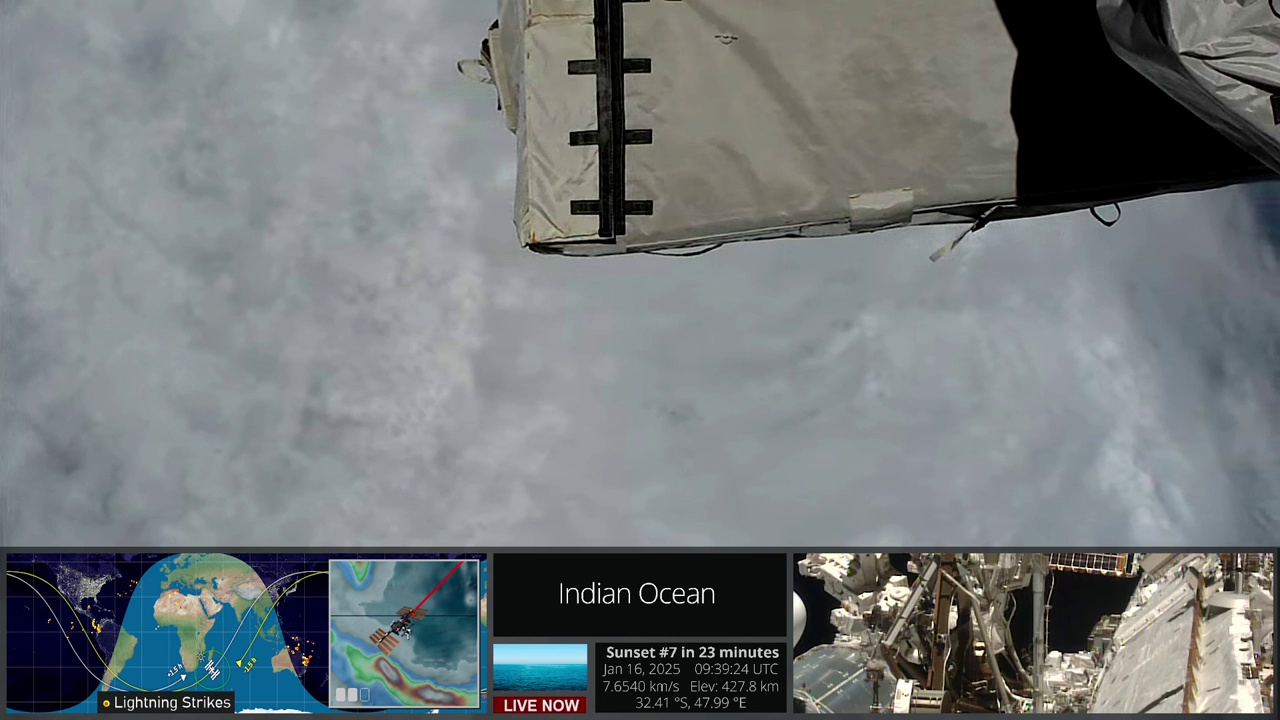

In [ ]:
#| eval: false
satellite_img = "/home/nghivo/tinyMLaaS/llmcam/data/cap_2025.01.16_11:39:47_satellite.jpg"
Image(satellite_img)

In [ ]:
#| export
SATELLITE_INFO = {
    "properties": {
      "timestamp": {
        "type": "string",
        "format": "date-time",
        "description": "The exact timestamp when the satellite image was captured."
      },
      "location": {
        "type": "string",
        "description": "The primary location or region of the image (e.g., Indian Ocean)."
      },
      "latitude": {
        "type": "number",
        "description": "The latitude of the image's focus area in decimal degrees."
      },
      "longitude": {
        "type": "number",
        "description": "The longitude of the image's focus area in decimal degrees."
      },
      "image_dimensions": {
        "type": "string",
        "description": "The pixel dimensions of the image, typically in width x height format."
      },
      "satellite_name": {
        "type": "string",
        "description": "The name of the satellite that captured the image (e.g., International Space Station)."
      },
      "sensor_type": {
        "type": "string",
        "description": "The type of sensor used for capturing the image (e.g., Optical, Infrared, Radar)."
      },
      "cloud_cover_percentage": {
        "type": "number",
        "description": "The percentage of the image obscured by clouds."
      },
      "land_cover_types": {
        "type": "array",
        "description": "List of land cover types visible in the image (e.g., ocean, forest, urban).",
        "items": {
          "type": "string"
        }
      },
      "waterbodies_detected": {
        "type": "boolean",
        "description": "Indicates whether water bodies are detected in the image."
      },
      "waterbodies_type": {
        "type": "string",
        "description": "The type of water bodies detected (e.g., Ocean, River, Lake).",
      },
      "urban_areas_detected": {
        "type": "boolean",
        "description": "Indicates whether urban areas are visible in the image."
      },
      "lightning_detected": {
        "type": "boolean",
        "description": "Indicates whether lightning strikes are detected in the image."
      },
      "vegetation_index": {
        "type": "number",
        "description": "Normalized vegetation index (e.g., NDVI) if vegetation is present.",
      },
      "thermal_anomalies_detected": {
        "type": "boolean",
        "description": "Indicates whether thermal anomalies are detected in the image."
      },
      "nighttime_imaging": {
        "type": "boolean",
        "description": "Indicates whether the image was captured at night."
      },
      "mins_to_sunset": {
        "type": "number",
        "format": "integer",
        "description": "The expected minutes until sunset if the image was captured near sunset."
      },
      "mins_to_sunrise": {
        "type": "number",
        "format": "integer",
        "description": "The expected minutes until sunrise if the image was captured near sunrise."
      },
      "satellite_speed_kms": {
        "type": "string",
        "description": "The speed of the satellite in km/s at the time of capture."
      },
      "satellite_altitude_km": {
        "type": "string",
        "description": "The altitude of the satellite in kilometers above the Earth's surface."
      },
    },
    "required": [
      "location",
      "image_dimensions",
      "satellite_name",
      "sensor_type",
      "cloud_cover_percentage",
      "waterbodies_detected",
      "urban_areas_detected",
      "lightning_detected",
      "thermal_anomalies_detected",
      "nighttime_imaging"
    ]
}

Lastly, we combine these formats and previous operations into a single function, with an indicator directing which output format to select:

In [ ]:
#| export
def ask_gpt4v_about_image_file(
        path: str,  # Path to the image file
        image_type: str = "city", # Type of image: "city" or "satellite", default is "city"
    ) -> str:  # JSON string with quantitative information
    """Tell all about quantitative information from a given image file"""
    info_format = CITY_INFO if image_type == "city" else SATELLITE_INFO
    response = openai.chat.completions.create(
      model="gpt-4o",
      messages=[{
            "role": "user",
            "content": [
                {"type": "text", "text": "Describe this image quantitatively as many as possible in json format."},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{encode_image(path)}", "detail":"high",},
                },
            ],
        }],
      functions=[
          {
              "name": "image_quantitative_analysis",
                "description": "Extract quantitative information from an image.",
                "parameters": {
                    "type": "object",
                    **info_format,
                    "additionalProperties": True
                }
          }
      ],
      function_call={"name": "image_quantitative_analysis"},
      max_tokens=300,
    )
    parsed_data = response.choices[0].message.function_call.arguments
    json_data = json.dumps(json.loads(parsed_data), indent=4)
    
    return json_data

In [ ]:
show_doc(ask_gpt4v_about_image_file)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/vision/gpt4v.py#L56){target="_blank" style="float:right; font-size:smaller"}

### ask_gpt4v_about_image_file

>      ask_gpt4v_about_image_file (path:str, image_type:str='city')

*Tell all about quantitative information from a given image file*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| path | str |  | Path to the image file |
| image_type | str | city | Type of image: "city" or "satellite", default is "city" |
| **Returns** | **str** |  | **JSON string with quantitative information** |

Test with the previous data files:

In [ ]:
#| eval: false
json.loads(ask_gpt4v_about_image_file(files[0]))

{'timestamp': '2024-09-28T15:59:06',
 'location': 'Presidentinlinna',
 'dimensions': '720x1280',
 'building': 10,
 'buildings_height_range': '3-5 stories',
 'car': 30,
 'truck': 3,
 'boat': 6,
 'available_parking_space': 5,
 'street_lights': 6,
 'person': 40,
 'time_of_day': 'afternoon',
 'artificial_lighting': 'low',
 'visibility_clear': True,
 'sky_visible': True,
 'sky_light_conditions': 'overcast',
 'waterbodies_visible': True,
 'waterbodies_type': 'harbor'}

In [ ]:
#| eval: false
json.loads(ask_gpt4v_about_image_file(satellite_img, "satellite"))

{'timestamp': '2025-01-16T09:39:24Z',
 'location': 'Indian Ocean',
 'latitude': -32.41,
 'longitude': 47.99,
 'image_dimensions': '1280x720',
 'satellite_name': 'International Space Station',
 'sensor_type': 'Optical',
 'cloud_cover_percentage': 90,
 'land_cover_types': ['ocean'],
 'waterbodies_detected': True,
 'waterbodies_type': 'Ocean',
 'urban_areas_detected': False,
 'lightning_detected': False,
 'thermal_anomalies_detected': False,
 'nighttime_imaging': False,
 'mins_to_sunset': 23,
 'satellite_speed_kms': '7.6540',
 'satellite_altitude_km': '427.8'}

## Simulated GPT workflow

This section tests integrating with our current GPT framework. This function can be used in combination with `ytlive` module:

In [ ]:
#| eval: false
from llmcam.core.fc import *
from llmcam.core.fn_to_schema import function_schema
from llmcam.vision.ytlive import *

tools = [
    function_schema(capture_youtube_live_frame, "Youtube Live Capture"),
    function_schema(select_youtube_live_url, "Youtube Live URL"),
    function_schema(ask_gpt4v_about_image_file, "GPT4 Vision"),
]
messages = form_msgs([
    ("system", "You are a helpful system administrator. Use the supplied tools to assist the user."),
    ("user", "Hi, can you capture a YouTube Live? Use the default link.")
])
complete(messages, tools=tools)
print_msgs(messages)

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading tv player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information
CPL CREME tele
cap_2025.01.16_13:05:52_unclear.jpg
>> System:
You are a helpful system administrator. Use the supplied tools to assist the user.
>> User:
Hi, can you capture a YouTube Live? Use the default link.
>> Assistant:
I have captured an image from the default YouTube Live stream. You can find it stored at the
following path: `/home/nghivo/tinyMLaaS/llmcam/data/cap_2025.01.16_13:05:52_unclear.jpg`.


In [ ]:
#| eval: false
# Continue the conversation and ask about the image file
messages.append(form_msg("user", "Can you extract information about this image?"))
complete(messages, tools=tools)
print_msgs(messages)

>> System:
You are a helpful system administrator. Use the supplied tools to assist the user.
>> User:
Hi, can you capture a YouTube Live? Use the default link.
>> Assistant:
I have captured an image from the default YouTube Live stream. You can find it stored at the
following path: `/home/nghivo/tinyMLaaS/llmcam/data/cap_2025.01.16_13:05:52_unclear.jpg`.
>> User:
Can you extract information about this image?
>> Assistant:
Here's the information extracted from the captured image:  - **Timestamp**: January 16, 2025, 12:56
PM - **Location**: Valkosaari - **Image Dimensions**: 1280x720 - **Buildings**: There are 5
buildings visible in the image. - **Buildings Height Range**: 2-4 stories - **Water Bodies
Visible**: Yes - **Type of Water Bodies**: Lake - **Sky Visible**: Yes - **Sky Light Conditions**:
Clear - **Visibility**: Clear - **Time of Day**: Afternoon - **Artificial Lighting**: Low  Feel free
to ask if you need more details or further assistance!


Another scenario using satellite live:

In [ ]:
#| eval: false
messages = form_msgs([
    ("system", "You are a helpful system administrator. Use the supplied tools to assist the user."),
    ("user", "Capture an image from satellite and extract information about it.")
])
complete(messages, tools=tools)
print_msgs(messages)

[youtube] Extracting URL: https://www.youtube.com/watch?v=xRPjKQtRXR8
[youtube] xRPjKQtRXR8: Downloading webpage
[youtube] xRPjKQtRXR8: Downloading ios player API JSON
[youtube] xRPjKQtRXR8: Downloading tv player API JSON
[youtube] xRPjKQtRXR8: Downloading m3u8 information
>> System:
You are a helpful system administrator. Use the supplied tools to assist the user.
>> User:
Capture an image from satellite and extract information about it.
>> Assistant:
The captured satellite image from the YouTube Live stream provides the following information:  -
**Timestamp:** 2025-01-16 at 11:06:44 UTC - **Location:** South Atlantic Ocean - **Latitude:**
-45.07 - **Longitude:** 3.68 - **Image Dimensions:** 1280x720 pixels - **Satellite Name:**
International Space Station - **Sensor Type:** Optical - **Cloud Cover Percentage:** 80% - **Land
Cover Types Detected:** Ocean, Cloud - **Waterbodies Detected:** Yes, specifically Ocean - **Urban
Areas Detected:** No - **Lightning Detected:** No - **Thermal A

In [ ]:
#|hide
import nbdev; nbdev.nbdev_export()